In [2]:
from dataclasses import dataclass
import itertools
import logging
import random
import math
import numpy as np
import json
import pickle
import time
import torch
import sys
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
from probe_utils import *

from omegaconf import OmegaConf
from pathlib import Path
from torch import nn, Tensor
from torch.nn import functional as F
from typing import List, Optional, Tuple
import os
# os.chdir("/data/tianyu_guo/birth")
from data import DataArgs, Dataset, iterate_batches, make_dataset
from ihead_full_model import ModelArgs, Transformer, forward_hook

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
run_path_server1="/data/tianyu_guo/birth/gens/pre_final/dormant_test"
run_path_server2="/data/tianyu_guo/birth/gens/special/dormant_copy_2"
model, cfg, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server1, n_layers=1, n_heads=1, bos_num=1, train_steps=5000, delim=0, with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu_guo/birth/data")
hook = forward_hook(target_layers=[], target_name="")
predicts, outputs_list = model.modified_forward_with_hook(x, hook)
model.cuda()

Transformer(
  (tok_embeddings): Embedding(67, 256)
  (pos_embeddings): Embedding(256, 256)
  (layers): ModuleList(
    (0): TransformerBlock(
      (attention): Attention(
        (wq): Linear(in_features=256, out_features=256, bias=False)
        (wk): Linear(in_features=256, out_features=256, bias=False)
        (wv): Linear(in_features=256, out_features=256, bias=False)
        (wo): Linear(in_features=256, out_features=256, bias=False)
      )
      (ff): FeedForward(
        (w1): Linear(in_features=256, out_features=1024, bias=False)
        (w2): Linear(in_features=1024, out_features=256, bias=False)
      )
      (attention_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ff_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
  )
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (output): Linear(in_features=256, out_features=67, bias=False)
)

In [6]:
trigger_toks, attns_to_0, markov_tok = get_triggers(ds, model, hook, cutoff=0.89)

In [3]:
# torch.cuda.empty_cache()
print(torch.cuda.mem_get_info())

(84538425344, 84986691584)


In [4]:
outputs_list_steps = {}
steps_list = []
n_layers, n_heads, bos_num = 1, 1, 1
# f"/data/tianyu_guo/birth/gens/special/dormant_copy_2/model_L{n_layers}_H{n_heads}_bos{bos_num}_delim0/state_{train_steps}.pt"
dir_name = f"/data/tianyu_guo/birth/gens/pre_final/dormant_test/model_L{n_layers}_H{n_heads}_bos{bos_num}_delim0"
model = model.cuda()
x = x.cuda()
with torch.no_grad():
    for fn in os.listdir(dir_name):
        if 'state' not in fn:
            continue
        step = int(fn.split('.')[0].split('_')[1])
        steps_list.append(step)
        state = torch.load(os.path.join(dir_name, fn), map_location="cuda")
        model.load_state_dict(state["model_state_dict"], strict=False, )
        predicts, outputs_list = model.modified_forward_with_hook(x, hook)
        outputs_list = move_device(outputs_list)
        outputs_list_steps[step] = outputs_list
        print(step)
steps_list.sort()

(83873628160, 84986691584)
(83869433856, 84986691584)
(83867336704, 84986691584)
(83867336704, 84986691584)
(83865239552, 84986691584)
(83865239552, 84986691584)
(83865239552, 84986691584)
(83865239552, 84986691584)
(83865239552, 84986691584)
(83863142400, 84986691584)
(83865239552, 84986691584)
(83863142400, 84986691584)
(83865239552, 84986691584)
(83863142400, 84986691584)
(83863142400, 84986691584)
(83863142400, 84986691584)
(83863142400, 84986691584)
(83863142400, 84986691584)
(83865239552, 84986691584)
(83863142400, 84986691584)
(83865239552, 84986691584)
(83863142400, 84986691584)
(83865239552, 84986691584)
(83863142400, 84986691584)
(83865239552, 84986691584)
(83863142400, 84986691584)
(83865239552, 84986691584)
(83863142400, 84986691584)
(83865239552, 84986691584)
(83863142400, 84986691584)
(83865239552, 84986691584)
(83863142400, 84986691584)
(83865239552, 84986691584)
(83863142400, 84986691584)
(83865239552, 84986691584)
(83863142400, 84986691584)
(83865239552, 84986691584)
(

In [131]:
len(steps_list)

205

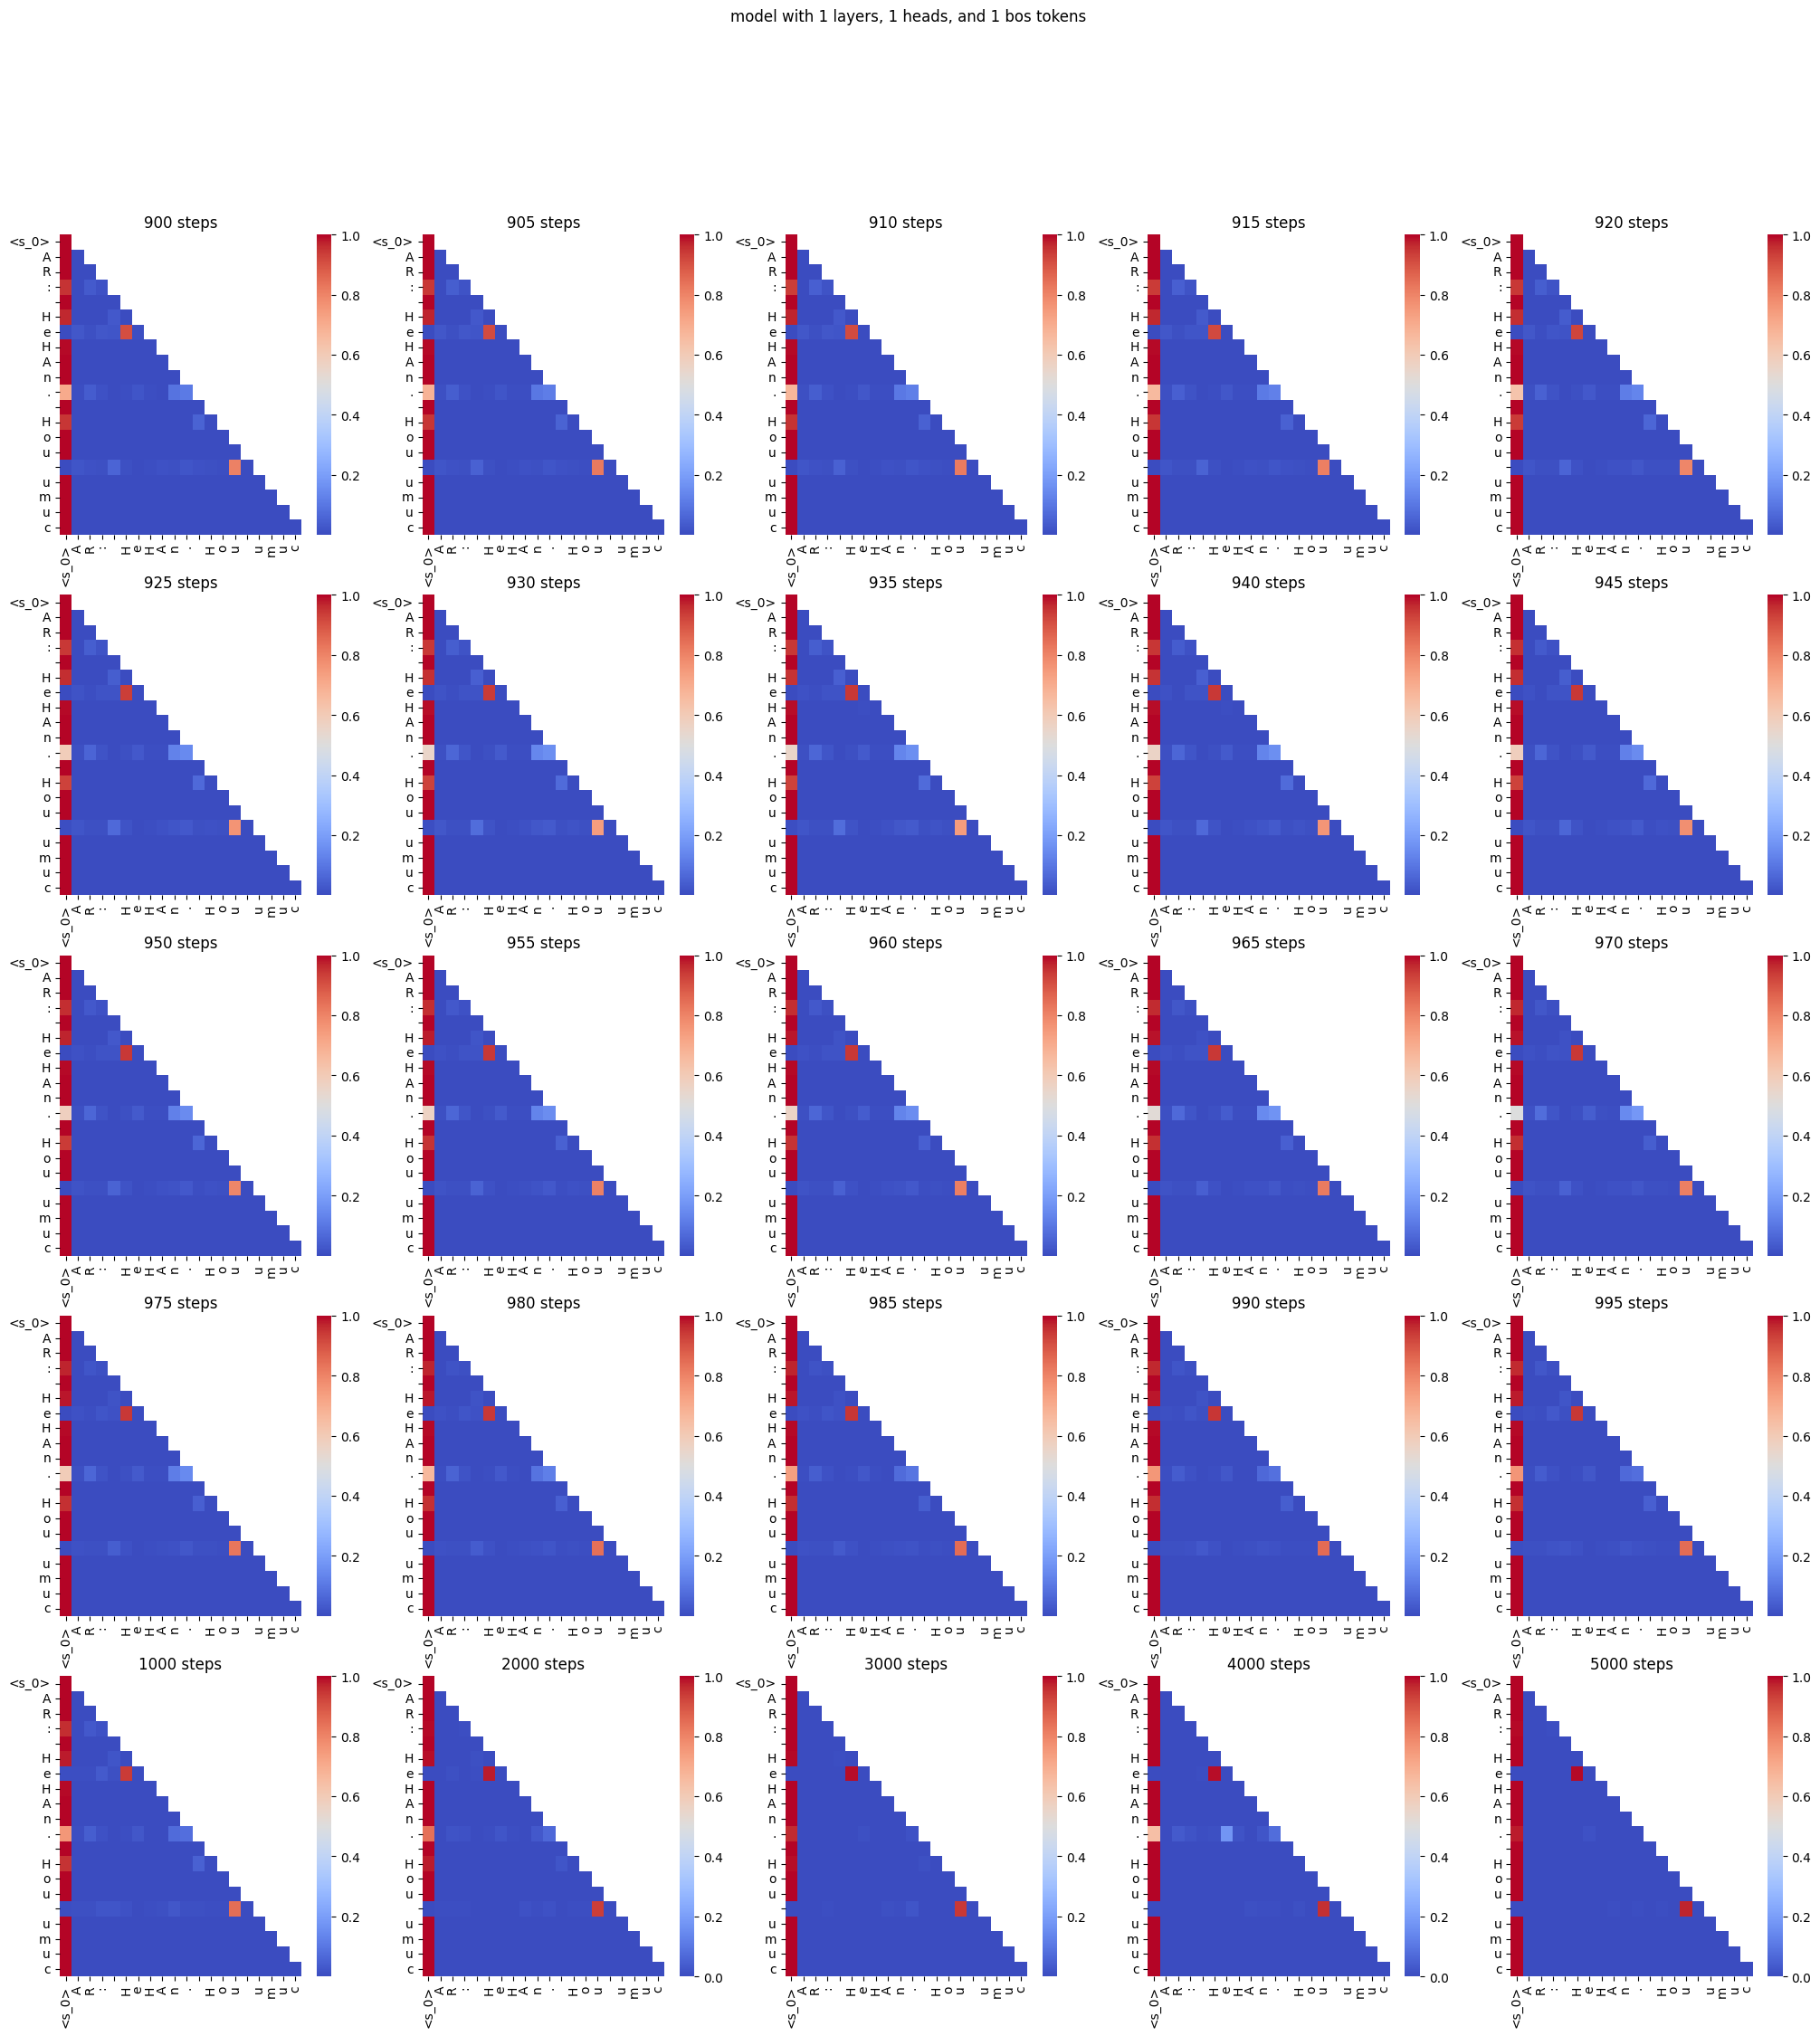

In [44]:
# scores = data['scores'][layer_idx]
start_step = 180
steps_subset = steps_list[start_step:start_step+25]
seq_len = 20
seq_idx = 6
text = ds.decode(x.detach().cpu()[seq_idx, :seq_len].numpy())

fig, axes = plt.subplots(5, 5, figsize=(5*5, 5*5))
axes = axes.flatten()

for i, ax in enumerate(axes):
    step = steps_subset[i]
    # hacky
    plot_attns(cfg, ax, seq_idx, 0, 0, seq_len, outputs_list_steps[step], text)
    # ax.set_xticks(list(ds.decode(x[seq_idx, :20].numpy())))
    ax.set_title(f"{step} steps")
fig.suptitle(f"model with {cfg.model_args['n_layers']} layers, {cfg.model_args['n_heads']} heads, and {cfg.model_args['bos_num']} bos tokens")
plt.show()

# try more fine-grained stuff

In [5]:
run_path_server1="/data/tianyu_guo/birth/gens/pre_final/dormant_copy"
run_path_server2="/data/tianyu_guo/birth/gens/special/dormant_copy_2"
model, cfg, x, y, ds = load_model(run_path_local="/Users/guotianyu/GitHub/birth/gens/special/markov", run_path_server=run_path_server1, n_layers=1, n_heads=1, bos_num=1, train_steps=5000, delim=0, with_data=True, data_path_local="/Users/guotianyu/GitHub/birth/data", data_path_server="/data/tianyu_guo/birth/data")
hook = forward_hook(target_layers=[], target_name="")
predicts, outputs_list = model.modified_forward_with_hook(x, hook)
model.cuda()

Transformer(
  (tok_embeddings): Embedding(67, 256)
  (pos_embeddings): Embedding(256, 256)
  (layers): ModuleList(
    (0): TransformerBlock(
      (attention): Attention(
        (wq): Linear(in_features=256, out_features=256, bias=False)
        (wk): Linear(in_features=256, out_features=256, bias=False)
        (wv): Linear(in_features=256, out_features=256, bias=False)
        (wo): Linear(in_features=256, out_features=256, bias=False)
      )
      (ff): FeedForward(
        (w1): Linear(in_features=256, out_features=1024, bias=False)
        (w2): Linear(in_features=1024, out_features=256, bias=False)
      )
      (attention_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ff_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
  )
  (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (output): Linear(in_features=256, out_features=67, bias=False)
)

In [33]:
outputs_list_steps = {}
trigger_toks_steps = {}
attns_to_0_steps = {}
loss_steps = {}
icl_loss_steps = {}
markov_loss_steps = {}
steps_list = []
n_layers, n_heads, bos_num = 1, 1, 1
# f"/data/tianyu_guo/birth/gens/special/dormant_copy_2/model_L{n_layers}_H{n_heads}_bos{bos_num}_delim0/state_{train_steps}.pt"
dir_name = f"/data/tianyu_guo/birth/gens/pre_final/dormant_copy/model_L{n_layers}_H{n_heads}_bos{bos_num}_delim0"
model = model.cuda()
x = x.cuda()
y = y.cuda()
x_cpu = x.cpu()
i = 0
sub_steps = np.arange(100, 1020, 40).tolist()
with torch.no_grad():
    for fn in os.listdir(dir_name):
        if 'state' not in fn:
            continue
        step = int(fn.split('.')[0].split('_')[1])
        steps_list.append(step)
        state = torch.load(os.path.join(dir_name, fn), map_location="cuda")
        model.load_state_dict(state["model_state_dict"], strict=False, )
        trigger_toks, attns_to_0, markov_tok = get_triggers(ds, model, hook, cutoff=0.89)
        predicts, outputs_list = model.modified_forward_with_hook(x, hook)
        triggers_pos = ds.get_triggers_pos(x_cpu)
        trigger_pos = torch.from_numpy(triggers_pos).cuda()
        loss = F.cross_entropy(predicts.flatten(0, 1), y.flatten(0, 1))
        icl_loss = F.cross_entropy(predicts[triggers_pos, :], y[triggers_pos])
        markov_loss = F.cross_entropy(predicts[~triggers_pos, :], y[~triggers_pos])
        outputs_list = move_device(outputs_list)
        loss_steps[step] = loss
        icl_loss_steps[step] = icl_loss
        markov_loss_steps[step] = markov_loss
        outputs_list_steps[step] = outputs_list
        trigger_toks_steps[step] = trigger_toks
        attns_to_0_steps[step] = attns_to_0
        i += 1
        print(i)
steps_list.sort()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [44]:
triggers_steps = [(step, len(toks)) for step, toks in trigger_toks_steps.items()]
triggers_steps.sort(key=lambda x: x[0])
icl_loss_steps_sorted = [(step, loss) for step, loss in icl_loss_steps.items()]
icl_loss_steps_sorted.sort(key=lambda x: x[0])
markov_loss_steps_sorted = [(step, loss) for step, loss in markov_loss_steps.items()]
markov_loss_steps_sorted.sort(key=lambda x: x[0])

In [68]:
triggers_pos.shape

(512, 256)

In [70]:
avg_attns_to_0 = [(step, outputs_list[0]['attn_weights'][:, 0, :, 0][~triggers_pos].mean()) for step, outputs_list in outputs_list_steps.items()]
avg_attns_to_0.sort(key=lambda x: x[0])

In [71]:
avg_attns_to_0

[(0, tensor(0.0225)),
 (20, tensor(0.0210)),
 (40, tensor(0.0201)),
 (60, tensor(0.0215)),
 (80, tensor(0.0229)),
 (100, tensor(0.0267)),
 (120, tensor(0.0358)),
 (140, tensor(0.0528)),
 (160, tensor(0.0801)),
 (180, tensor(0.1269)),
 (200, tensor(0.1995)),
 (220, tensor(0.3050)),
 (240, tensor(0.4167)),
 (260, tensor(0.4842)),
 (280, tensor(0.5242)),
 (300, tensor(0.5468)),
 (320, tensor(0.5624)),
 (340, tensor(0.5765)),
 (360, tensor(0.5948)),
 (380, tensor(0.6094)),
 (400, tensor(0.6205)),
 (420, tensor(0.6260)),
 (440, tensor(0.6299)),
 (460, tensor(0.6353)),
 (480, tensor(0.6384)),
 (500, tensor(0.6422)),
 (520, tensor(0.6470)),
 (540, tensor(0.6530)),
 (560, tensor(0.6621)),
 (580, tensor(0.6650)),
 (600, tensor(0.6698)),
 (620, tensor(0.6764)),
 (640, tensor(0.6806)),
 (660, tensor(0.6889)),
 (680, tensor(0.6964)),
 (700, tensor(0.7094)),
 (720, tensor(0.7087)),
 (740, tensor(0.7189)),
 (760, tensor(0.7282)),
 (780, tensor(0.7364)),
 (800, tensor(0.7443)),
 (820, tensor(0.7459))

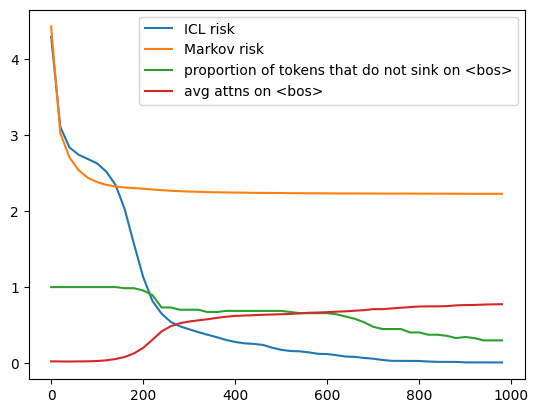

In [75]:
truncation = 50
plt.plot(steps_list[:truncation], list(map(lambda x: x[1].detach().cpu(), icl_loss_steps_sorted))[:truncation], label="ICL risk")
plt.plot(steps_list[:truncation], list(map(lambda x: x[1].detach().cpu(), markov_loss_steps_sorted))[:truncation], label="Markov risk")
plt.plot(steps_list[:truncation], list(map(lambda x: x[1]/len(ds.tok_range), triggers_steps))[:truncation], label="proportion of tokens that do not sink on <bos>")
plt.plot(steps_list[:truncation], list(map(lambda x: x[1], avg_attns_to_0))[:truncation], label="avg attns on <bos>")
plt.legend()

<Axes: title={'center': 'Layer0 Head0'}>

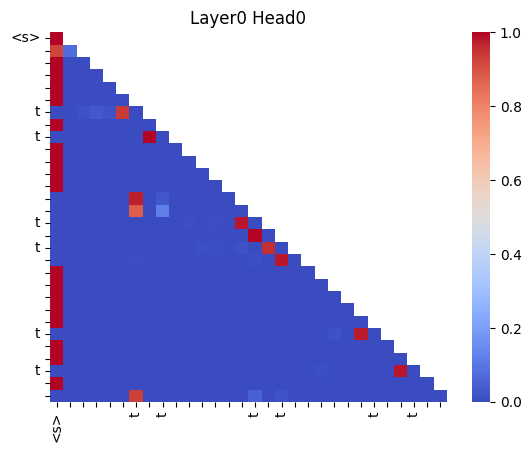

In [60]:
fig, ax = plt.subplots()
seq_idx = 100
seq_len = 30
sub_seq = x.cpu().detach().numpy()[seq_idx, :seq_len].tolist()
text = ['t' if idx in ds.idxs else ' ' for idx in sub_seq]
text[0] = '<s>'
# text = ds.decode(sub_seq)
text
step = 9980
plot_attns(cfg, ax, seq_idx, 0, 0, seq_len, outputs_list_steps[step], text)

In [57]:
triggers_steps

[(0, 67),
 (20, 67),
 (40, 67),
 (60, 67),
 (80, 67),
 (100, 67),
 (120, 67),
 (140, 67),
 (160, 66),
 (180, 66),
 (200, 64),
 (220, 60),
 (240, 49),
 (260, 49),
 (280, 47),
 (300, 47),
 (320, 47),
 (340, 45),
 (360, 45),
 (380, 46),
 (400, 46),
 (420, 46),
 (440, 46),
 (460, 46),
 (480, 46),
 (500, 46),
 (520, 45),
 (540, 44),
 (560, 44),
 (580, 44),
 (600, 44),
 (620, 43),
 (640, 41),
 (660, 39),
 (680, 36),
 (700, 32),
 (720, 30),
 (740, 30),
 (760, 30),
 (780, 27),
 (800, 27),
 (820, 25),
 (840, 25),
 (860, 24),
 (880, 22),
 (900, 23),
 (920, 22),
 (940, 20),
 (960, 20),
 (980, 20),
 (1000, 18),
 (1020, 16),
 (1040, 16),
 (1060, 17),
 (1080, 16),
 (1100, 17),
 (1120, 17),
 (1140, 16),
 (1160, 19),
 (1180, 19),
 (1200, 19),
 (1220, 16),
 (1240, 15),
 (1260, 17),
 (1280, 15),
 (1300, 18),
 (1320, 17),
 (1340, 16),
 (1360, 18),
 (1380, 18),
 (1400, 17),
 (1420, 15),
 (1440, 19),
 (1460, 19),
 (1480, 19),
 (1500, 20),
 (1520, 19),
 (1540, 17),
 (1560, 18),
 (1580, 14),
 (1600, 15),
 (1

<BarContainer object of 67 artists>

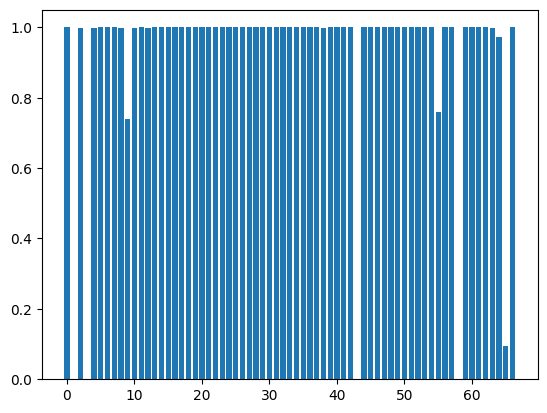

In [59]:
plt.bar(ds.tok_range, attns_to_0_steps[9980])